C:\Users\lyf86\AppData\Local\Temp\ipykernel_1196\916354005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WA['Electric Vehicle Type'] = df_WA['Electric Vehicle Type'].replace({


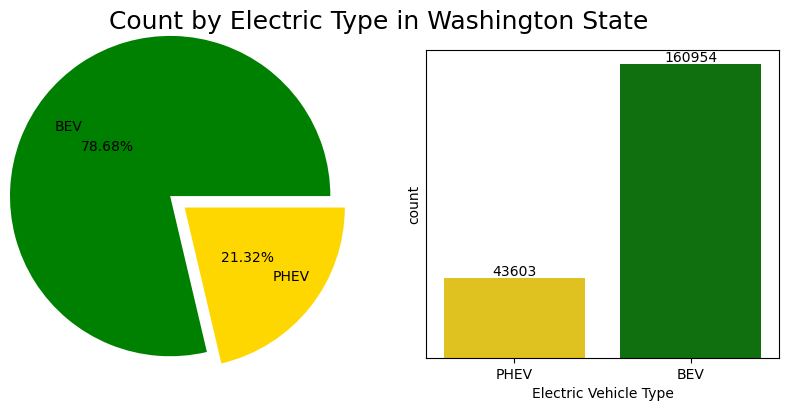

In [75]:
# Simplify Electric Vehicle Type labels
df_WA['Electric Vehicle Type'] = df_WA['Electric Vehicle Type'].replace({
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV',
    'Battery Electric Vehicle (BEV)': 'BEV'
})

# Create pivot table
count_elect_type = pd.pivot_table(df_WA, values='VIN (1-10)' , 
                       index=['Electric Vehicle Type'],
                       aggfunc={'count'}, fill_value=0)

# Plot the data
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1,2,1)
elec_type_colors = ['green', 'gold']
count_elect_type['count'].plot.pie(autopct='%.2f%%', radius=1.3,
                        explode=[0.1, 0.05], colors=elec_type_colors,
                        pctdistance=0.5, labeldistance=0.7)
plt.ylabel('')

# Bar plot
plt.subplot(1,2,2)
ax = sns.countplot(data=df_WA, x='Electric Vehicle Type', palette=['gold', 'green'])
for count in ax.containers:
    ax.bar_label(count)
plt.yticks([])

# Add title
plt.suptitle('Count by Electric Type in Washington State', fontsize=18)

# Show plot
plt.show()


In [45]:
!pip install folium
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from collections import Counter

# Load data
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Extract longitude from the 'Vehicle Location' field
def extract_longitude(location):
    if isinstance(location, str):
        return float(location.split(' ')[1][1:])
    return None

# Extract latitude from the 'Vehicle Location' field
def extract_latitude(location):
    if isinstance(location, str):
        return float(location.split(' ')[2][:-1])
    return None

df['Longitude'] = df['Vehicle Location'].apply(extract_longitude)
df['Latitude'] = df['Vehicle Location'].apply(extract_latitude)

# Filter points within the state of Washington (WA)
df = df.dropna(subset=['Longitude', 'Latitude'])
df = df[(df['Latitude'] >= 45.5) & (df['Latitude'] <= 49.0) &
        (df['Longitude'] >= -124.0) & (df['Longitude'] <= -116.9)]

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth (in kilometers)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Compute the distance matrix for latitude and longitude
coordinates = df[['Latitude', 'Longitude']].to_numpy()
n_clusters = 20

# Initialize random cluster centers
np.random.seed(42)
initial_centers = coordinates[np.random.choice(coordinates.shape[0], n_clusters, replace=False)]

# Custom KMeans implementation
for _ in range(100):  # Maximum of 100 iterations
    # Compute the distance matrix (Haversine distance)
    distances = np.array([
        [haversine(lat1, lon1, center[0], center[1]) for center in initial_centers]
        for lat1, lon1 in coordinates
    ])
    # Assign each point to the nearest cluster center
    labels = np.argmin(distances, axis=1)
    # Recompute the cluster centers
    new_centers = np.array([
        coordinates[labels == cluster].mean(axis=0) if np.any(labels == cluster) else center
        for cluster, center in enumerate(initial_centers)
    ])
    # Check for convergence
    if np.allclose(initial_centers, new_centers, atol=1e-4):
        break
    initial_centers = new_centers

cluster_centers = initial_centers
df['Cluster'] = labels

# Visualization
mc = MarkerCluster()
map_usa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],
                     tiles='cartodbpositron', zoom_start=6)

# Add cluster centers to the map
for i, (lat, lon) in enumerate(cluster_centers):
    print(f"Adding Cluster {i} at location: ({lat}, {lon})")
    mc.add_child(folium.Marker(
        location=[lat, lon],
        popup=f"Cluster {i}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ))

# Add the MarkerCluster to the map
map_usa.add_child(mc)
map_usa


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple/
Adding Cluster 0 at location: (47.65432221917686, -122.33787987462414)
Adding Cluster 1 at location: (47.55359328568717, -121.96772031382308)
Adding Cluster 2 at location: (47.65767267913633, -122.61910352125608)
Adding Cluster 3 at location: (46.36376200091013, -119.44554286752629)
Adding Cluster 4 at location: (46.98699579625857, -122.91942659539589)
Adding Cluster 5 at location: (47.524334385972885, -120.32784274110493)
Adding Cluster 6 at location: (47.59482864600288, -122.17555869434354)
Adding Cluster 7 at location: (47.39061672571619, -122.63325790749158)
Adding Cluster 8 at location: (47.675682872370686, -122.11592948572029)
Adding Cluster 9 at location: (48.08025516926353, -122.21261106319055)
Adding Cluster 10 at location: (47.55601136758049, -122.33735097446096)
Adding Cluster 11 at location: (47.19160956004928, -122.37793534804618)
Adding Cluster 12 at 

D:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


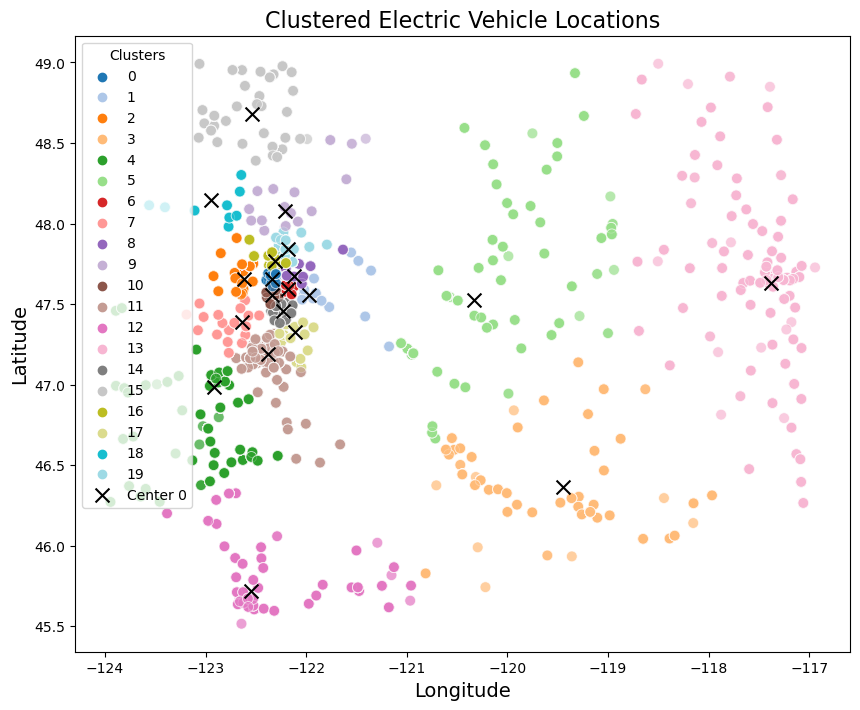

In [44]:
import seaborn as sns
# Create a scatter plot of the clustered points
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['Longitude'], y=df['Latitude'], hue=df['Cluster'], palette='tab20', s=60, alpha=0.7)

# Plot the cluster centers
for i, (lat, lon) in enumerate(cluster_centers):
    plt.scatter(lon, lat, color='black', s=100, marker='x', label=f"Center {i}" if i == 0 else "")  # Mark the center with black 'x'

# Set the plot labels
plt.title("Clustered Electric Vehicle Locations", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Show the legend
plt.legend(title="Clusters")

# Display the plot
plt.show()

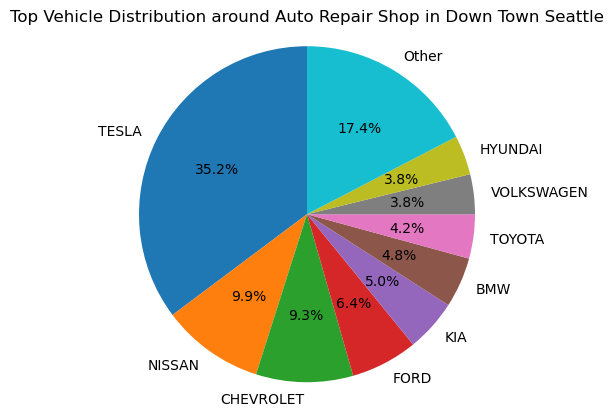

In [43]:

# Count the number of each make of the EV around cluster 10
cluster_10_points = df[df['Cluster'] == 10]
vehicle_counts = Counter(cluster_10_points['Make'])

# Get the top five vehicle makes.
most_common_vehicles = vehicle_counts.most_common(9)

other_count = sum(count for _, count in vehicle_counts.most_common()[9:])
if other_count > 0:
    most_common_vehicles.append(('Other', other_count))

# Extract vehicle make names and their counts.
vehicle_labels, vehicle_values = zip(*most_common_vehicles)


# Plot a pie chart for the vehicle distribution in Cluster 10.
def plot_pie_chart(vehicle_labels, vehicle_values):
    fig, ax = plt.subplots()
    ax.pie(vehicle_values, labels=vehicle_labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  
    plt.title("Top Vehicle Distribution around Auto Repair Shop in Down Town Seattle")
    plt.show()

plot_pie_chart(vehicle_labels, vehicle_values)



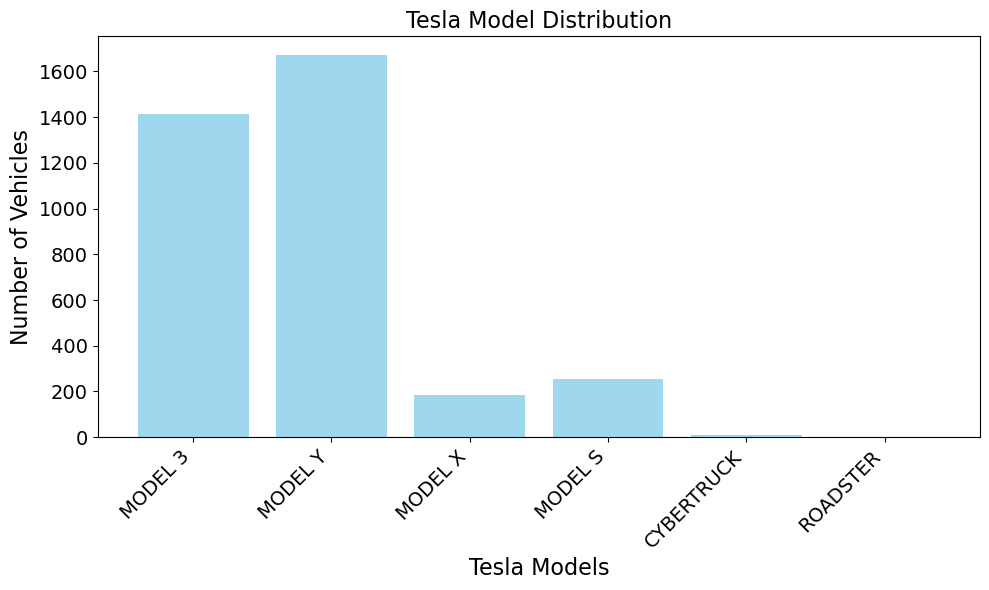

In [35]:
# Shatter Tesla in the vehicle around cluster 10
tesla_models = cluster_10_points[cluster_10_points['Make'] == 'TESLA']['Model']

# Count the number of different models of Tesla
tesla_model_counts = Counter(tesla_models)

# Get the name and count of each model
model_labels, model_values = zip(*tesla_model_counts.items())

# Draw bar chart
def plot_bar_chart(model_labels, model_values):
    plt.figure(figsize=(10, 6))
    plt.bar(model_labels, model_values, color='skyblue', alpha=0.8)
    plt.xlabel("Tesla Models", fontsize=16)
    plt.ylabel("Number of Vehicles", fontsize=16)
    plt.title("Tesla Model Distribution", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)  # X 轴刻度标签字体大小
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45, ha='right')  # 旋转 X 轴标签
    plt.tight_layout()
    plt.show()

plot_bar_chart(model_labels, model_values)

C:\Users\lyf86\AppData\Local\Temp\ipykernel_1196\3645924301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Electric Vehicle Type'] = filtered_data['Electric Vehicle Type'].replace({


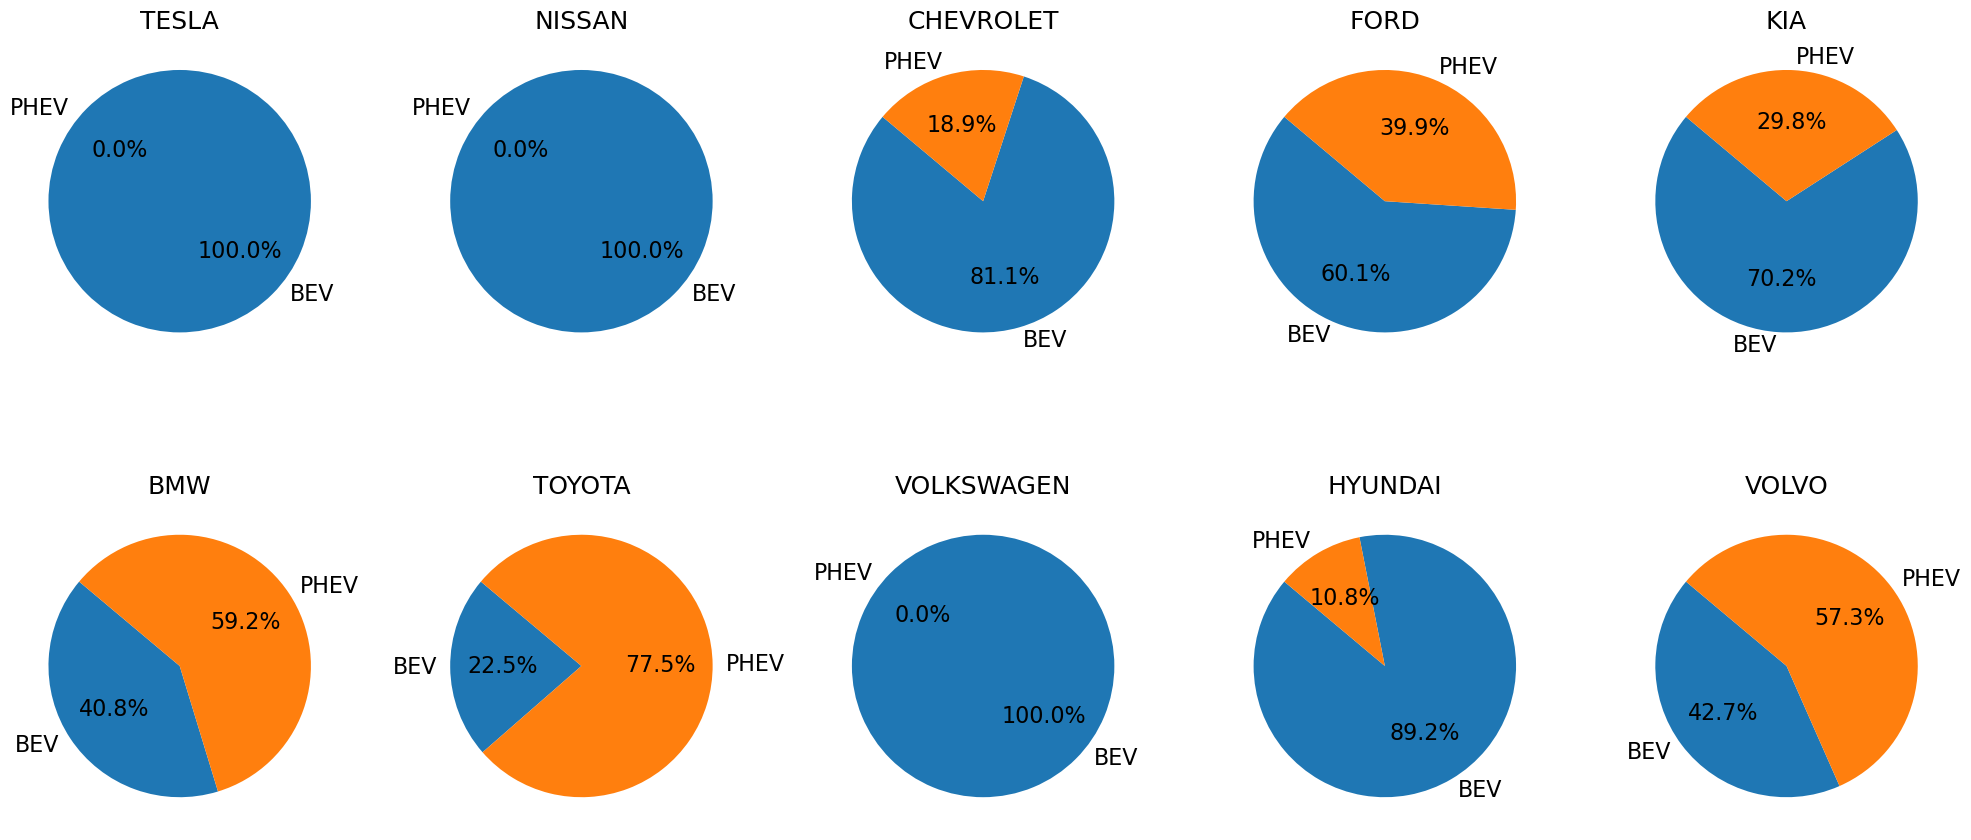

In [39]:
import matplotlib.pyplot as plt


cluster_10_data = df[df['Cluster'] == 10]

top_10_makes = cluster_10_data['Make'].value_counts().head(10).index
filtered_data = cluster_10_data[cluster_10_data['Make'].isin(top_10_makes)]


filtered_data['Electric Vehicle Type'] = filtered_data['Electric Vehicle Type'].replace({
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV',
    'Battery Electric Vehicle (BEV)': 'BEV'
})

distribution = filtered_data.groupby(['Make', 'Electric Vehicle Type']).size().unstack(fill_value=0)


fig, axes = plt.subplots(2, 5, figsize=(20, 10))  
axes = axes.flatten()

for i, make in enumerate(top_10_makes):
    if make in distribution.index:
        values = distribution.loc[make]
        labels = values.index
        wedges, texts, autotexts = axes[i].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
        
        axes[i].set_title(f'{make}', fontsize=18)
        for text in texts:
            text.set_fontsize(16)
        for autotext in autotexts:
            autotext.set_fontsize(16)
    else:
        axes[i].axis('off')  

plt.tight_layout()
plt.show()
